In [ ]:
# 建模与训练
def getModel():
    input_layer = Input(shape=(x.shape[1],))
    encoded = Dense(8, activation='relu', activity_regularizer=regularizers.l2(10e-5))(input_layer)  # l2正则化约束
    decoded = Dense(x.shape[1], activation='relu')(encoded)
    autoencoder = Model(input_layer, decoded)
    autoencoder.compile(optimizer='adam', loss='mean_squared_error')
    return autoencoder

In [ ]:
# calculate_losses是一个辅助函数，计算每个数据样本的重建损失
def calculate_losses(x, preds):
    losses = np.zeros(len(x))
    for i in range(len(x)):
        losses[i] = ((preds[i] - x[i]) ** 2).mean(axis=None)
    return losses

In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import tensorflow as tf
import seaborn as sns
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint
from keras import regularizers
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc, precision_recall_curve

Using TensorFlow backend.


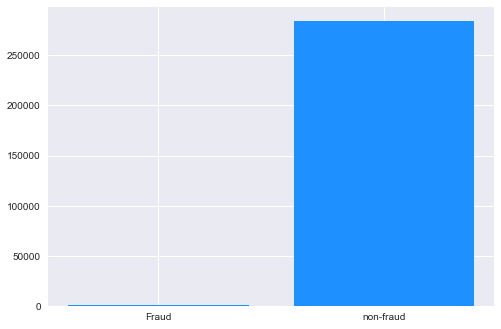

In [2]:
# 读取数据
d = pd.read_csv('SofaSofa_Anomaly.csv')

# 查看样本比例
num_nonfraud = np.sum(d['Class'] == 0)
num_fraud = np.sum(d['Class'] == 1)
plt.bar(['Fraud', 'non-fraud'], [num_fraud, num_nonfraud], color='dodgerblue')
plt.show()

In [13]:
d

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.360,-0.073,2.536,1.378,-0.338,0.462,0.240,0.099,0.364,...,-0.018,0.278,-0.110,0.067,0.129,-0.189,0.134,-0.021,149.62,0
1,0.0,1.192,0.266,0.166,0.448,0.060,-0.082,-0.079,0.085,-0.255,...,-0.226,-0.639,0.101,-0.340,0.167,0.126,-0.009,0.015,2.69,0
2,1.0,-1.358,-1.340,1.773,0.380,-0.503,1.800,0.791,0.248,-1.515,...,0.248,0.772,0.909,-0.689,-0.328,-0.139,-0.055,-0.060,378.66,0
3,1.0,-0.966,-0.185,1.793,-0.863,-0.010,1.247,0.238,0.377,-1.387,...,-0.108,0.005,-0.190,-1.176,0.647,-0.222,0.063,0.061,123.50,0
4,2.0,-1.158,0.878,1.549,0.403,-0.407,0.096,0.593,-0.271,0.818,...,-0.009,0.798,-0.137,0.141,-0.206,0.502,0.219,0.215,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881,10.072,-9.835,-2.067,-5.364,-2.607,-4.918,7.305,1.914,...,0.213,0.112,1.014,-0.509,1.437,0.250,0.944,0.824,0.77,0
284803,172787.0,-0.733,-0.055,2.035,-0.739,0.868,1.058,0.024,0.295,0.585,...,0.214,0.924,0.012,-1.016,-0.607,-0.395,0.068,-0.054,24.79,0
284804,172788.0,1.920,-0.301,-3.250,-0.558,2.631,3.031,-0.297,0.708,0.432,...,0.232,0.578,-0.038,0.640,0.266,-0.087,0.004,-0.027,67.88,0
284805,172788.0,-0.240,0.530,0.703,0.690,-0.378,0.624,-0.686,0.679,0.392,...,0.265,0.800,-0.163,0.123,-0.569,0.547,0.109,0.105,10.00,0


In [3]:
# 删除时间列，对Amount进行标准化
data = d.drop(['Time'], axis=1)
data['Amount'] = StandardScaler().fit_transform(data[['Amount']])

In [4]:
# 提取负样本，并且按照8:2切成训练集和测试集
mask = (data['Class'] == 0)
X_train, X_test = train_test_split(data[mask], test_size=0.2, random_state=920)
X_train = X_train.drop(['Class'], axis=1).values
X_test = X_test.drop(['Class'], axis=1).values

# 提取所有正样本，作为测试集的一部分
X_fraud = data[~mask].drop(['Class'], axis=1).values

In [5]:
# 设置Autoencoder的参数
# 隐藏层节点数分别为16，8，8，16
# epoch为50，batch size为32
input_dim = X_train.shape[1]
encoding_dim = 16
num_epoch = 50
batch_size = 32

input_layer = Input(shape=(input_dim, ))
# 五层结构:X -> 16 -> 8 -> 16 -> X'
encoder = Dense(encoding_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)
decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['mae'])

In [6]:
# 模型保存为SofaSofa_model.h5，并开始训练模型
checkpointer = ModelCheckpoint(filepath="SofaSofa_model.h5",
                               verbose=0,
                               save_best_only=True)
start = time.clock()
history = autoencoder.fit(X_train, X_train,
                          epochs=num_epoch,
                          batch_size=batch_size,
                          shuffle=True,
                          validation_data=(X_test, X_test),
                          verbose=1, 
                          callbacks=[checkpointer]).history
end = time.clock()
print('Time : ', (end - start))

Train on 227452 samples, validate on 56863 samples
Epoch 1/50
227452/227452 [==============================] - 9s 39us/step - loss: 0.7917 - mae: 0.5334 - val_loss: 0.7439 - val_mae: 0.5096
Epoch 2/50
227452/227452 [==============================] - 10s 43us/step - loss: 0.7259 - mae: 0.5043 - val_loss: 0.7266 - val_mae: 0.5025
Epoch 3/50
227452/227452 [==============================] - 10s 43us/step - loss: 0.7153 - mae: 0.4998 - val_loss: 0.7226 - val_mae: 0.5015
Epoch 4/50
227452/227452 [==============================] - 9s 41us/step - loss: 0.7081 - mae: 0.4965 - val_loss: 0.7157 - val_mae: 0.4988
Epoch 5/50
227452/227452 [==============================] - 10s 43us/step - loss: 0.7039 - mae: 0.4948 - val_loss: 0.7093 - val_mae: 0.4959
Epoch 6/50
227452/227452 [==============================] - 10s 42us/step - loss: 0.7019 - mae: 0.4939 - val_loss: 0.7079 - val_mae: 0.4950
Epoch 7/50
227452/227452 [==============================] - 9s 41us/step - loss: 0.7003 - mae: 0.4935 - val_los

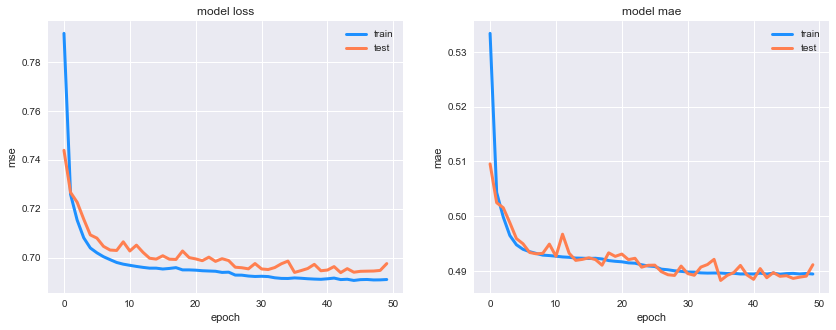

In [7]:
# 画出损失函数曲线
plt.figure(figsize=(14, 5))
plt.subplot(121)
plt.plot(history['loss'], c='dodgerblue', lw=3)
plt.plot(history['val_loss'], c='coral', lw=3)
plt.title('model loss')
plt.ylabel('mse'); plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

plt.subplot(122)
plt.plot(history['mae'], c='dodgerblue', lw=3)
plt.plot(history['val_mae'], c='coral', lw=3)
plt.title('model mae')
plt.ylabel('mae'); plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

In [8]:
# 读取模型
autoencoder = load_model('SofaSofa_model.h5')

# 利用训练好的autoencoder重建测试集
pred_test = autoencoder.predict(X_test)
pred_fraud = autoencoder.predict(X_fraud)

# 计算还原误差MSE和MAE
mse_test = np.mean(np.power(X_test - pred_test, 2), axis=1)
mse_fraud = np.mean(np.power(X_fraud - pred_fraud, 2), axis=1)
mae_test = np.mean(np.abs(X_test - pred_test), axis=1)
mae_fraud = np.mean(np.abs(X_fraud - pred_fraud), axis=1)
mse_df = pd.DataFrame()
mse_df['Class'] = [0] * len(mse_test) + [1] * len(mse_fraud)
mse_df['MSE'] = np.hstack([mse_test, mse_fraud])
mse_df['MAE'] = np.hstack([mae_test, mae_fraud])
mse_df = mse_df.sample(frac=1).reset_index(drop=True)

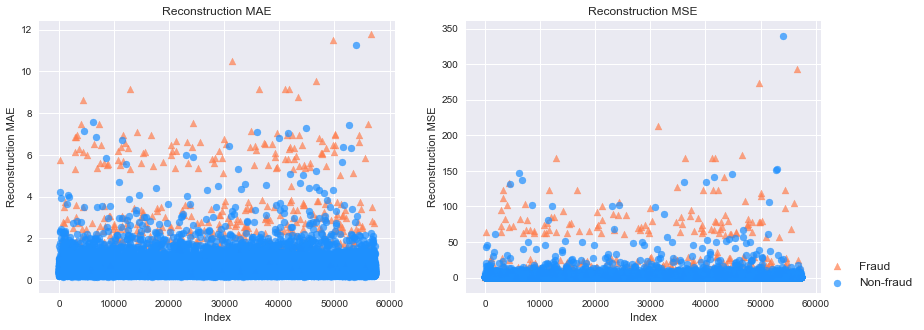

In [9]:
# 分别画出测试集中正样本和负样本的还原误差MAE和MSE
markers = ['o', '^']
markers = ['o', '^']
colors = ['dodgerblue', 'coral']
labels = ['Non-fraud', 'Fraud']

plt.figure(figsize=(14, 5))
plt.subplot(121)
for flag in [1, 0]:
    temp = mse_df[mse_df['Class'] == flag]
    plt.scatter(temp.index, 
                temp['MAE'],  
                alpha=0.7, 
                marker=markers[flag], 
                c=colors[flag], 
                label=labels[flag])
plt.title('Reconstruction MAE')
plt.ylabel('Reconstruction MAE'); plt.xlabel('Index')
plt.subplot(122)
for flag in [1, 0]:
    temp = mse_df[mse_df['Class'] == flag]
    plt.scatter(temp.index, 
                temp['MSE'],  
                alpha=0.7, 
                marker=markers[flag], 
                c=colors[flag], 
                label=labels[flag])
plt.legend(loc=[1, 0], fontsize=12); plt.title('Reconstruction MSE')
plt.ylabel('Reconstruction MSE'); plt.xlabel('Index')
plt.show()

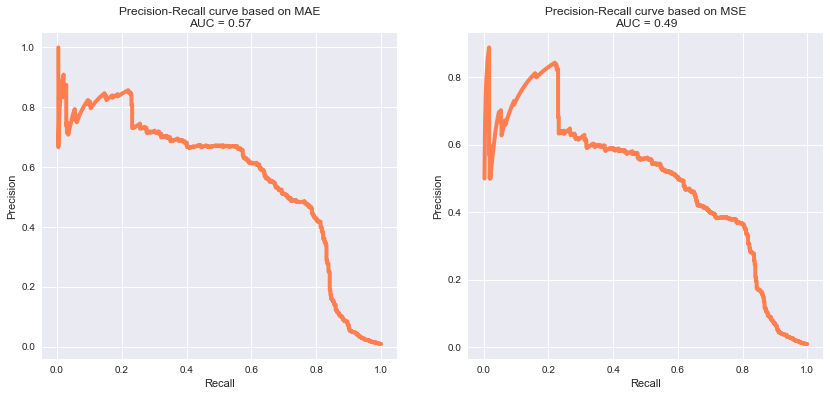

In [10]:
# 画出Precision-Recall曲线
plt.figure(figsize=(14, 6))
for i, metric in enumerate(['MAE', 'MSE']):
    plt.subplot(1, 2, i+1)
    precision, recall, _ = precision_recall_curve(mse_df['Class'], mse_df[metric])
    pr_auc = auc(recall, precision)
    plt.title('Precision-Recall curve based on %s\nAUC = %0.2f'%(metric, pr_auc))
    plt.plot(recall[:-2], precision[:-2], c='coral', lw=4)
    plt.xlabel('Recall'); plt.ylabel('Precision')
plt.show()

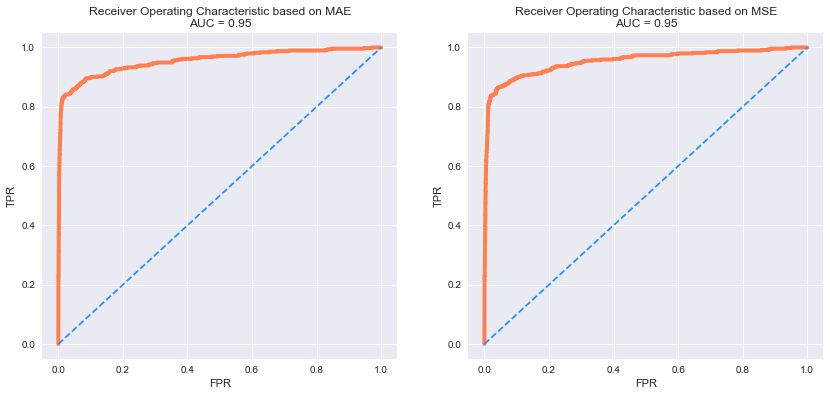

In [11]:
# 画出ROC曲线
plt.figure(figsize=(14, 6))
for i, metric in enumerate(['MAE', 'MSE']):
    plt.subplot(1, 2, i+1)
    fpr, tpr, _ = roc_curve(mse_df['Class'], mse_df[metric])
    roc_auc = auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic based on %s\nAUC = %0.2f'%(metric, roc_auc))
    plt.plot(fpr, tpr, c='coral', lw=4)
    plt.plot([0,1],[0,1], c='dodgerblue', ls='--')
    plt.ylabel('TPR'); plt.xlabel('FPR')
plt.show()

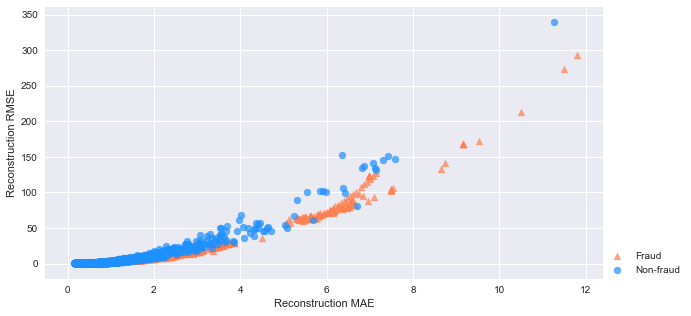

In [12]:
# 画出MSE、MAE散点图
markers = ['o', '^']
colors = ['dodgerblue', 'coral']
labels = ['Non-fraud', 'Fraud']

plt.figure(figsize=(10, 5))
for flag in [1, 0]:
    temp = mse_df[mse_df['Class'] == flag]
    plt.scatter(temp['MAE'], 
                temp['MSE'],  
                alpha=0.7, 
                marker=markers[flag], 
                c=colors[flag], 
                label=labels[flag])
plt.legend(loc=[1, 0])
plt.ylabel('Reconstruction RMSE'); plt.xlabel('Reconstruction MAE')
plt.show()